In [1]:
import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import networkx as nx
from tqdm.auto import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/fv1_model_chunked/checkpoint-117000"
GRID_SIZE = 4
WALK_LENGTH = 100
NUM_RUNS_PER_TYPE = 500

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed()

def generate_grid_graph(size=4):
    """Generates a grid graph with coordinate metadata."""
    G = nx.DiGraph()
    nodes = [f"{chr(97+r)}{chr(97+c)}" for r in range(size) for c in range(size)]
    direction_map = {'N': 'NORTH', 'S': 'SOUTH', 'E': 'EAST', 'W': 'WEST'}
    for r in range(size):
        for c in range(size):
            idx = r * size + c
            G.add_node(nodes[idx], coords=(r, c))
            if c < size - 1: G.add_edge(nodes[idx], nodes[idx+1], direction=direction_map['E'])
            if c > 0: G.add_edge(nodes[idx], nodes[idx-1], direction=direction_map['W'])
            if r < size - 1: G.add_edge(nodes[idx], nodes[idx+size], direction=direction_map['S'])
            if r > 0: G.add_edge(nodes[idx], nodes[idx-size], direction=direction_map['N'])
    return G

def generate_random_walk(G, start_node, length):
    """Generate a random walk of specified length."""
    path = [start_node]
    for _ in range(length - 1):
        neighbors = list(G.successors(path[-1]))
        if not neighbors: break
        path.append(random.choice(neighbors))
    return path

def walk_to_string(walk, G):
    """Convert walk to string format."""
    if not walk or len(walk) < 2: return walk[0] if walk else ""
    parts = [f"{walk[i]} {G.edges[walk[i], walk[i+1]]['direction']}" for i in range(len(walk) - 1)]
    return " ".join(parts) + f" {walk[-1]}"

def swap_directions_robust(prompt):
    swap_map = {'NORTH': 'SOUTH', 'SOUTH': 'NORTH', 'EAST': 'WEST', 'WEST': 'EAST'}
    return ' '.join([swap_map.get(part, part) for part in prompt.split(' ')])

def get_hidden_states(model, tokens):
    cache = {}
    hooks = []
    def save_hook(layer_idx):
        def hook_fn(module, input, output):
            cache[layer_idx] = output[0].detach().cpu()
        return hook_fn
    for i, block in enumerate(model.transformer.h):
        hooks.append(block.register_forward_hook(save_hook(i)))
    with torch.no_grad():
        model(**tokens)
    for h in hooks: h.remove()
    return [cache[i] for i in range(model.config.n_layer)]

def run_direction_swap_experiment(model, tokenizer, G, walk_type='corner'):
    coords = nx.get_node_attributes(G, 'coords')
    target_nodes = []
    if walk_type == 'center':
        center_coords = [(r, c) for r in range(1, GRID_SIZE-1) for c in range(1, GRID_SIZE-1)]
        target_nodes = [n for n, (r, c) in coords.items() if (r, c) in center_coords]
    elif walk_type == 'edge':
        edge_nodes = []
        corners = [(0,0), (0,GRID_SIZE-1), (GRID_SIZE-1,0), (GRID_SIZE-1,GRID_SIZE-1)]
        for n, (r, c) in coords.items():
            is_on_border = (r == 0 or r == GRID_SIZE - 1 or c == 0 or c == GRID_SIZE - 1)
            if is_on_border and (r, c) not in corners:
                edge_nodes.append(n)
        target_nodes = edge_nodes
    elif walk_type == 'corner':
        corners = [(0,0), (0,GRID_SIZE-1), (GRID_SIZE-1,0), (GRID_SIZE-1,GRID_SIZE-1)]
        target_nodes = [n for n, (r, c) in coords.items() if (r, c) in corners]
    else:
        raise ValueError("walk_type must be 'center', 'edge', or 'corner'")
    if not target_nodes:
        raise ValueError(f"No target nodes found for walk_type '{walk_type}'")

    target_node = random.choice(target_nodes)
    while True:
        start_node = random.choice(list(G.nodes()))
        walk = generate_random_walk(G, start_node, WALK_LENGTH)
        if walk[-1] == target_node:
            break

    base_prompt = walk_to_string(walk, G)
    original_prompt = base_prompt + " "
    swapped_prompt = swap_directions_robust(base_prompt) + " "
    
    orig_tokens = tokenizer(original_prompt, return_tensors="pt").to(DEVICE)
    swap_tokens = tokenizer(swapped_prompt, return_tensors="pt").to(DEVICE)
    
    orig_hiddens = get_hidden_states(model, orig_tokens)
    swap_hiddens = get_hidden_states(model, swap_tokens)

    cos_sims = []
    for i in range(model.config.n_layer):
        h1 = orig_hiddens[i][0, -1, :].numpy()
        h2 = swap_hiddens[i][0, -1, :].numpy()
        cos_sim = np.dot(h1, h2) / (np.linalg.norm(h1) * np.linalg.norm(h2) + 1e-8)
        cos_sims.append(cos_sim)
        
    return cos_sims

def plot_averaged_swap_figure(model, tokenizer, G):
    """
    Runs the swap experiment multiple times for each condition, then plots the
    mean similarity with standard deviation error bands.
    """
    all_results = {'center': [], 'edge': [], 'corner': []}
    
    for walk_type in ['center', 'edge', 'corner']:
        print(f"\nCollecting data for '{walk_type}' case ({NUM_RUNS_PER_TYPE} runs)...")
        for _ in tqdm(range(NUM_RUNS_PER_TYPE)):
            sims = run_direction_swap_experiment(model, tokenizer, G, walk_type)
            all_results[walk_type].append(sims)

    mean_sims = {}
    std_sims = {}
    for walk_type, results in all_results.items():
        results_array = np.array(results)
        mean_sims[walk_type] = np.mean(results_array, axis=0)
        std_sims[walk_type] = np.std(results_array, axis=0)

    print("\n" + "="*50)
    print("Final Layer Cosine Similarity (Mean ± 95% CI)")
    print("="*50)

    z_score = 1.96 # For 95% confidence interval
    for walk_type in ['center', 'edge', 'corner']:
        final_layer_mean = mean_sims[walk_type][-1]
        final_layer_std = std_sims[walk_type][-1]
        
        # Calculate standard error and the confidence interval margin
        standard_error = final_layer_std / np.sqrt(NUM_RUNS_PER_TYPE)
        ci_margin = z_score * standard_error
        
        print(f"{walk_type.capitalize():<8}: {final_layer_mean:.4f} ± {ci_margin:.4f}")
    print("="*50 + "\n")

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(8, 6))

    layers = np.arange(1, model.config.n_layer + 1)
    
    colors = {'center': 'green', 'edge': 'purple', 'corner': 'red'}
    styles = {'center': ':', 'edge': '-', 'corner': '--'}
    markers = {'center': '^', 'edge': 'o', 'corner': 's'}
    labels = {'center': 'Center Node', 'edge': 'Edge Node', 'corner': 'Corner Node'}

    for walk_type in ['center', 'edge', 'corner']:
        mean = mean_sims[walk_type]
        std = std_sims[walk_type]
        
        ax.plot(layers, mean, marker=markers[walk_type], linestyle=styles[walk_type], 
                color=colors[walk_type], label=labels[walk_type])
        
        ax.fill_between(layers, mean - std, mean + std, color=colors[walk_type], alpha=0.15)
    
    #ax.set_title("Model 1", fontsize=14)
    ax.set_xlabel("Layer", fontsize=12)
    ax.set_ylabel("Cosine Similarity", fontsize=12)
    #ax.set_ylim(-0.05, 1.05)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xticks(layers)
    ax.legend(fontsize=12, title="Node Type")
    plt.tight_layout()
    plt.show()

# if __name__ == "__main__":
#     print("Loading model and tokenizer...")
#     tokenizer = GPT2TokenizerFast.from_pretrained(MODEL_PATH)
#     model = GPT2LMHeadModel.from_pretrained(MODEL_PATH)
#     model.to(DEVICE)
#     model.eval()
#     print("Model loaded successfully.")
    
#     G = generate_grid_graph(size=GRID_SIZE)
    
#     plot_averaged_swap_figure(model, tokenizer, G)

/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


Loading model and tokenizer...
Model loaded successfully.



100%|██████████| 500/500 [00:07<00:00, 70.07it/s]


100%|██████████| 500/500 [00:07<00:00, 69.27it/s]


100%|██████████| 500/500 [00:07<00:00, 67.72it/s]



Final Layer Cosine Similarity (Mean ± 95% CI)
Center  : 0.9883 ± 0.0002
Edge    : 0.7136 ± 0.0010
Corner  : 0.3099 ± 0.0011



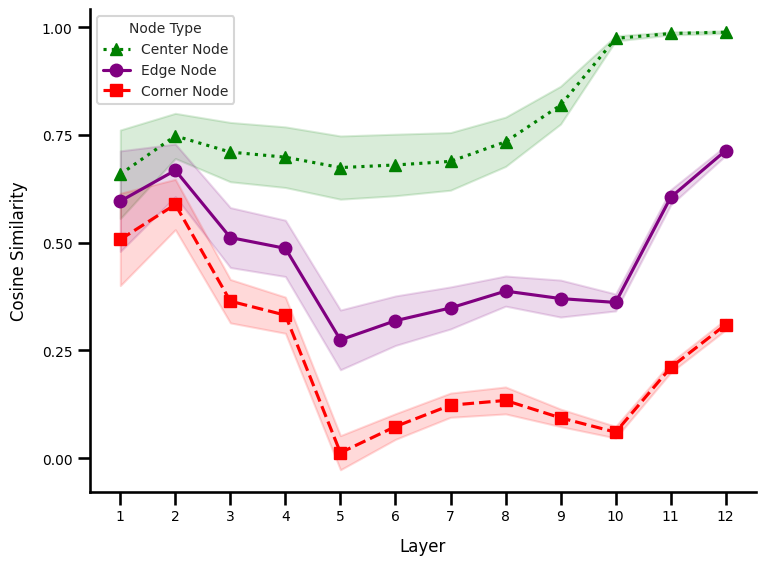

In [ ]:
import seaborn as sns
def plot_averaged_swap_figure(model, tokenizer, G):
    """
    Runs the swap experiment multiple times for each condition, then plots the
    mean similarity with standard deviation error bands.
    """
    all_results = {'center': [], 'edge': [], 'corner': []}
    
    for walk_type in ['center', 'edge', 'corner']:
        print(f"\nCollecting data for '{walk_type}' case ({NUM_RUNS_PER_TYPE} runs)...")
        for _ in tqdm(range(NUM_RUNS_PER_TYPE)):
            sims = run_direction_swap_experiment(model, tokenizer, G, walk_type)
            all_results[walk_type].append(sims)

    mean_sims = {}
    std_sims = {}
    for walk_type, results in all_results.items():
        results_array = np.array(results)
        mean_sims[walk_type] = np.mean(results_array, axis=0)
        std_sims[walk_type] = np.std(results_array, axis=0)

    print("\n" + "="*50)
    print("Final Layer Cosine Similarity (Mean ± 95% CI)")
    print("="*50)

    z_score = 1.96
    for walk_type in ['center', 'edge', 'corner']:
        final_layer_mean = mean_sims[walk_type][-1]
        final_layer_std = std_sims[walk_type][-1]
        
        standard_error = final_layer_std / np.sqrt(NUM_RUNS_PER_TYPE)
        ci_margin = z_score * standard_error
        
        print(f"{walk_type.capitalize():<8}: {final_layer_mean:.4f} ± {ci_margin:.4f}")
    print("="*50 + "\n")

    plt.rcParams.update({
        "axes.edgecolor": "black",
        "axes.linewidth": 2,
        "xtick.color": "black",
        "ytick.color": "black",
        "axes.labelcolor": "black",
        "xtick.major.width": 2,
        "ytick.major.width": 2,
        "xtick.major.size": 7,
        "ytick.major.size": 7,
    })
    sns.set_theme(style="ticks", context="talk", rc={
        "axes.edgecolor": "black",
        "axes.labelcolor": "black",
        "xtick.color": "black",
        "ytick.color": "black",
    })

    fig, ax = plt.subplots(figsize=(8, 6))
    layers = np.arange(1, model.config.n_layer + 1)

    colors = {'center': 'green', 'edge': 'purple', 'corner': 'red'}
    styles = {'center': ':', 'edge': '-', 'corner': '--'}
    markers = {'center': '^', 'edge': 'o', 'corner': 's'}
    labels = {'center': 'Center Node', 'edge': 'Edge Node', 'corner': 'Corner Node'}

    for walk_type in ['center', 'edge', 'corner']:
        mean = mean_sims[walk_type]
        std = std_sims[walk_type]
        
        ax.plot(layers, mean, marker=markers[walk_type], linestyle=styles[walk_type], 
                color=colors[walk_type], label=labels[walk_type])
        
        ax.fill_between(layers, mean - std, mean + std, color=colors[walk_type], alpha=0.15)

    ax.set_xlabel("Layer", fontsize=12, labelpad=10)
    ax.set_ylabel("Cosine Similarity", fontsize=12, labelpad=10)
    ax.set_xticks(layers)
    ax.set_yticks(np.linspace(0, 1, 5))
    ax.tick_params(axis='both', which='major', labelsize=10)

    ax.legend(fontsize=10, title="Node Type", title_fontsize=10)  
    sns.despine()
    plt.tight_layout()
    plt.show()

MODEL_PATH= "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/fv1_model/checkpoint-33000"
if __name__ == "__main__":
    print("Loading model and tokenizer...")
    tokenizer = GPT2TokenizerFast.from_pretrained(MODEL_PATH)
    model = GPT2LMHeadModel.from_pretrained(MODEL_PATH)
    model.to(DEVICE)
    model.eval()
    print("Model loaded successfully.")
    
    G = generate_grid_graph(size=GRID_SIZE)
    
    plot_averaged_swap_figure(model, tokenizer, G)

Loading model and tokenizer...
Model loaded successfully.



  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [01:21<00:00,  6.16it/s]


100%|██████████| 500/500 [01:19<00:00,  6.27it/s]


100%|██████████| 500/500 [01:19<00:00,  6.26it/s]


100%|██████████| 500/500 [01:19<00:00,  6.26it/s]


100%|██████████| 500/500 [01:20<00:00,  6.18it/s]


100%|██████████| 500/500 [01:22<00:00,  6.07it/s]


100%|██████████| 500/500 [01:22<00:00,  6.08it/s]


100%|██████████| 500/500 [01:25<00:00,  5.84it/s]


100%|██████████| 500/500 [01:26<00:00,  5.79it/s]


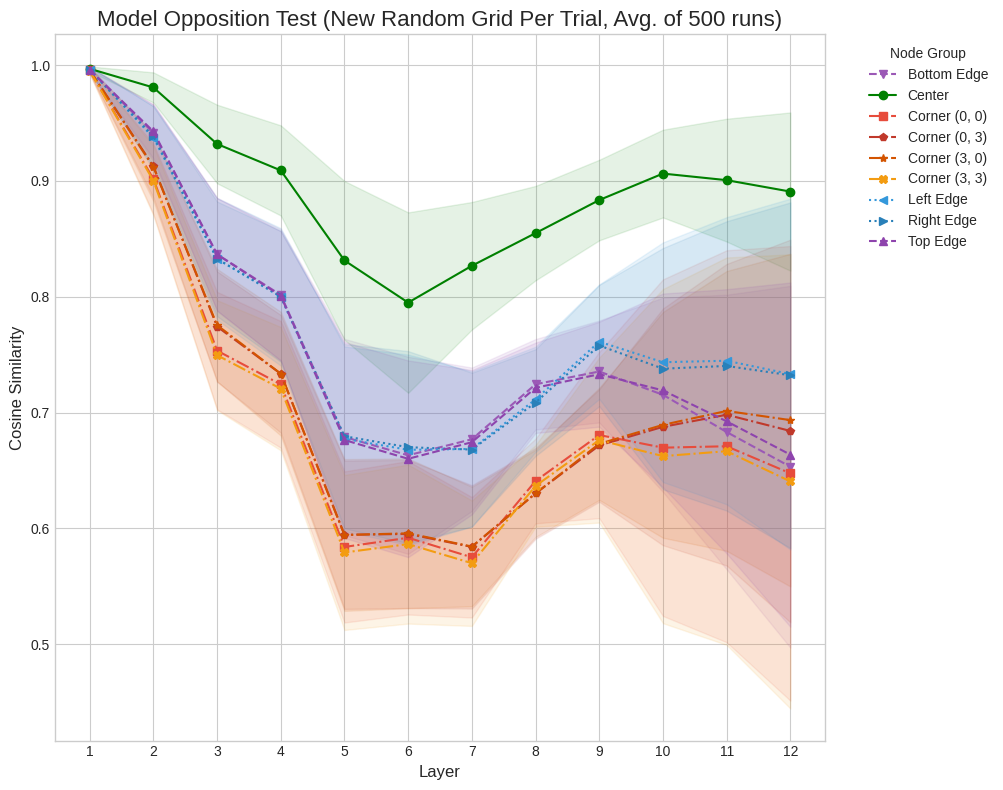

In [ ]:
import os
import random
import string
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import networkx as nx
from tqdm.auto import tqdm
from collections import defaultdict

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/fv1_model_chunked/checkpoint-73125"
GRID_SIZE = 4
WALK_LENGTH = 100
NUM_RUNS_PER_TYPE = 500 

def generate_random_names(count):
    """Generate unique random 2-letter names."""
    names = set()
    while len(names) < count:
        names.add(''.join(random.choices(string.ascii_lowercase, k=2)))
    return list(names)

def generate_grid_graph_random_names(size=4):
    """Generates a grid graph with coordinate metadata and RANDOMIZED node names."""
    G = nx.DiGraph()
    num_nodes = size * size
    random_names = generate_random_names(num_nodes)
    coord_to_name = {(r, c): random_names[r * size + c] for r in range(size) for c in range(size)}
    direction_map = {'N': 'NORTH', 'S': 'SOUTH', 'E': 'EAST', 'W': 'WEST'}
    for r in range(size):
        for c in range(size):
            current_coord = (r, c)
            current_name = coord_to_name[current_coord]
            G.add_node(current_name, coords=current_coord)
            if c < size - 1: G.add_edge(current_name, coord_to_name[(r, c + 1)], direction=direction_map['E'])
            if c > 0: G.add_edge(current_name, coord_to_name[(r, c - 1)], direction=direction_map['W'])
            if r < size - 1: G.add_edge(current_name, coord_to_name[(r + 1, c)], direction=direction_map['S'])
            if r > 0: G.add_edge(current_name, coord_to_name[(r - 1, c)], direction=direction_map['N'])
    return G, coord_to_name

def generate_random_walk(G, start_node, length):
    path = [start_node]
    for _ in range(length - 1):
        neighbors = list(G.successors(path[-1]))
        if not neighbors: break
        path.append(random.choice(neighbors))
    return path

def walk_to_string(walk, G):
    if not walk or len(walk) < 2: return walk[0] if walk else ""
    parts = [f"{walk[i]} {G.edges[walk[i], walk[i+1]]['direction']}" for i in range(len(walk) - 1)]
    return " ".join(parts) + f" {walk[-1]}"

def swap_directions_robust(prompt):
    swap_map = {'NORTH': 'SOUTH', 'SOUTH': 'NORTH', 'EAST': 'WEST', 'WEST': 'EAST'}
    return ' '.join([swap_map.get(part, part) for part in prompt.split(' ')])

def get_hidden_states(model, tokens):
    cache = {}
    hooks = []
    def save_hook(layer_idx):
        def hook_fn(module, input, output):
            cache[layer_idx] = output[0].detach().cpu()
        return hook_fn
    for i, block in enumerate(model.transformer.h):
        hooks.append(block.register_forward_hook(save_hook(i)))
    with torch.no_grad():
        model(**tokens)
    for h in hooks: h.remove()
    return [cache[i] for i in range(model.config.n_layer)]



def run_swap_trial_on_new_grid(model, tokenizer, target_coord, grid_size, walk_length):
    """
    Performs a single swap experiment trial. Critically, it generates a new
    grid with new random names for each call.
    """

    G, coord_to_name = generate_grid_graph_random_names(size=grid_size)
    target_node_name = coord_to_name[target_coord]
    

    while True:
        start_node = random.choice(list(G.nodes()))
        walk = generate_random_walk(G, start_node, walk_length)
        if walk[-1] == target_node_name:
            break

    base_prompt = walk_to_string(walk, G)
    original_prompt = base_prompt + " "
    swapped_prompt = swap_directions_robust(base_prompt) + " "
    
    orig_tokens = tokenizer(original_prompt, return_tensors="pt").to(DEVICE)
    swap_tokens = tokenizer(swapped_prompt, return_tensors="pt").to(DEVICE)
    
    orig_hiddens = get_hidden_states(model, orig_tokens)
    swap_hiddens = get_hidden_states(model, swap_tokens)

    cos_sims = []
    for i in range(model.config.n_layer):
        h1 = orig_hiddens[i][0, -1, :].numpy()
        h2 = swap_hiddens[i][0, -1, :].numpy()
        cos_sim = np.dot(h1, h2) / (np.linalg.norm(h1) * np.linalg.norm(h2) + 1e-8)
        cos_sims.append(cos_sim)
        
    return cos_sims


def plot_averaged_swap_figure(model, tokenizer):
    """
    Defines abstract node groups by coordinates, runs the swap experiment for each,
    generating a new grid for every trial, then plots the results.
    """

    group_definitions = defaultdict(list)
    for r in range(GRID_SIZE):
        for c in range(GRID_SIZE):
            coord = (r, c)
            if (r == 0 or r == GRID_SIZE - 1) and (c == 0 or c == GRID_SIZE - 1):
                group_definitions[f'Corner {coord}'].append(coord)
            elif r == 0: group_definitions['Top Edge'].append(coord)
            elif r == GRID_SIZE - 1: group_definitions['Bottom Edge'].append(coord)
            elif c == 0: group_definitions['Left Edge'].append(coord)
            elif c == GRID_SIZE - 1: group_definitions['Right Edge'].append(coord)
            else: group_definitions['Center'].append(coord)


    all_results = {group: [] for group in group_definitions.keys()}
    for group_name, coords_in_group in sorted(group_definitions.items()):
        print(f"\nCollecting data for '{group_name}' ({NUM_RUNS_PER_TYPE} runs)...")
        for _ in tqdm(range(NUM_RUNS_PER_TYPE)):
            # For each trial, pick a random coordinate from the group to be the target
            target_coord = random.choice(coords_in_group)
            sims = run_swap_trial_on_new_grid(model, tokenizer, target_coord, GRID_SIZE, WALK_LENGTH)
            all_results[group_name].append(sims)

    mean_sims = {}
    std_sims = {}
    for group_name, results in all_results.items():
        results_array = np.array(results)
        mean_sims[group_name] = np.mean(results_array, axis=0)
        std_sims[group_name] = np.std(results_array, axis=0)

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 8))
    layers = np.arange(1, model.config.n_layer + 1)
    
    styling = {
        'Center': {'color': 'green', 'marker': 'o', 'linestyle': '-'},
        'Top Edge': {'color': '#8e44ad', 'marker': '^', 'linestyle': '--'}, 
        'Bottom Edge': {'color': '#9b59b6', 'marker': 'v', 'linestyle': '--'},
        'Left Edge': {'color': '#3498db', 'marker': '<', 'linestyle': ':'}, 
        'Right Edge': {'color': '#2980b9', 'marker': '>', 'linestyle': ':'},
        f'Corner (0, 0)': {'color': '#e74c3c', 'marker': 's', 'linestyle': '-.'}, 
        f'Corner (0, {GRID_SIZE-1})': {'color': '#c0392b', 'marker': 'p', 'linestyle': '-.'},
        f'Corner ({GRID_SIZE-1}, 0)': {'color': '#d35400', 'marker': '*', 'linestyle': '-.'}, 
        f'Corner ({GRID_SIZE-1}, {GRID_SIZE-1})': {'color': '#f39c12', 'marker': 'X', 'linestyle': '-.'}
    }
    
    for group_name in sorted(mean_sims.keys()):
        mean = mean_sims[group_name]
        std = std_sims[group_name]
        style = styling.get(group_name, {})
        
        ax.plot(layers, mean, marker=style.get('marker'), linestyle=style.get('linestyle'), 
                color=style.get('color'), label=group_name)
        ax.fill_between(layers, mean - std, mean + std, color=style.get('color'), alpha=0.1)
    
    ax.set_title(f"Model Opposition Test (New Random Grid Per Trial, Avg. of {NUM_RUNS_PER_TYPE} runs)", fontsize=16)
    ax.set_xlabel("Layer", fontsize=12)
    ax.set_ylabel("Cosine Similarity", fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xticks(layers)
    ax.legend(fontsize=10, title="Node Group", bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()


if __name__ == "__main__":
    print("Loading model and tokenizer...")
    tokenizer = GPT2TokenizerFast.from_pretrained(MODEL_PATH)
    model = GPT2LMHeadModel.from_pretrained(MODEL_PATH)
    model.to(DEVICE)
    model.eval()
    print("Model loaded successfully.")
    
    plot_averaged_swap_figure(model, tokenizer)

Analyzing node distribution in '/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/fv1_data/train.txt'...


Processing walks: 100%|██████████| 1000000/1000000 [00:10<00:00, 96066.50it/s]



--- Node Distribution Analysis ---
Total nodes counted: 2,846,652
-----------------------------------
Node      | Count         | Probability
----------|---------------|------------
aa        | 175,605      |     6.1688%
ab        | 178,547      |     6.2722%
ac        | 180,273      |     6.3328%
ad        | 175,958      |     6.1812%
ba        | 178,095      |     6.2563%
bb        | 176,607      |     6.2040%
bc        | 177,747      |     6.2441%
bd        | 179,656      |     6.3111%
ca        | 180,571      |     6.3433%
cb        | 178,986      |     6.2876%
cc        | 177,597      |     6.2388%
cd        | 178,698      |     6.2775%
da        | 177,472      |     6.2344%
db        | 177,772      |     6.2450%
dc        | 176,883      |     6.2137%
dd        | 176,185      |     6.1892%


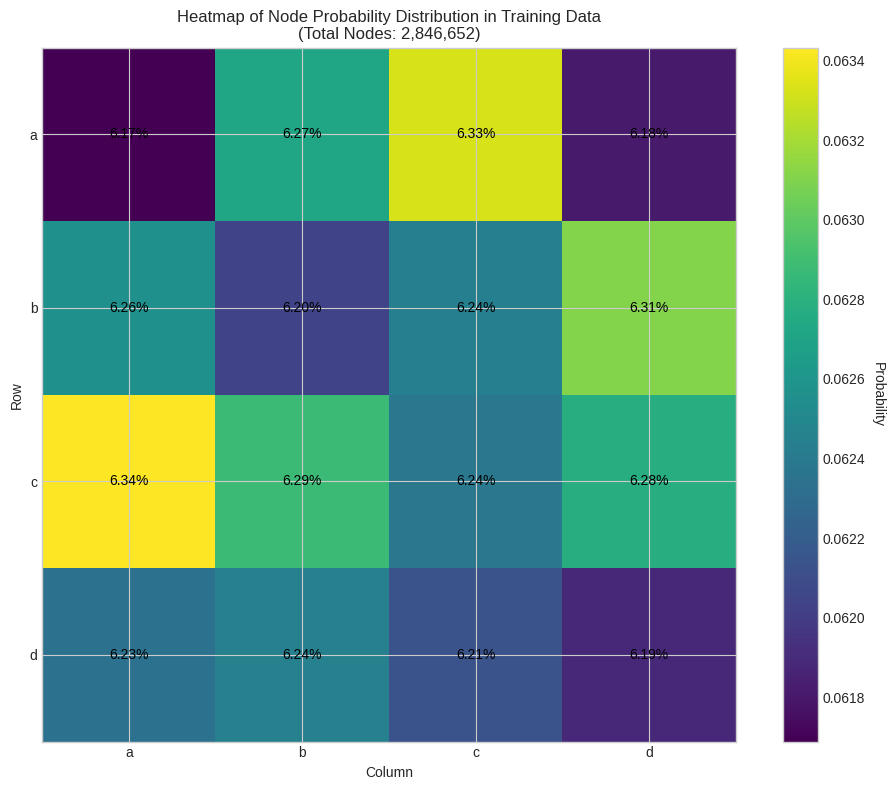

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.auto import tqdm


FILE_PATH = "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/fv1_data/train.txt"
GRID_SIZE = 4

def analyze_node_distribution(file_path, grid_size=4):
    """
    Reads a file of walks, counts the occurrences of each node, and displays the distribution.
    """
    if not os.path.exists(file_path):
        print(f"Error: The file was not found at '{file_path}'")
        return

    # Generate the set of valid node names for quick lookups
    valid_nodes = {f"{chr(97+r)}{chr(97+c)}" for r in range(grid_size) for c in range(grid_size)}
    name_to_coord = {name: (ord(name[0]) - 97, ord(name[1]) - 97) for name in valid_nodes}
    
    node_counts = defaultdict(int)
    total_node_count = 0

    print(f"Analyzing node distribution in '{file_path}'...")
    
    try:
        with open(file_path, 'r') as f:
            num_lines = sum(1 for line in f)
    except Exception as e:
        print(f"Could not read file to get line count: {e}")
        return

    with open(file_path, 'r') as f:
        for line in tqdm(f, total=num_lines, desc="Processing walks"):
            parts = line.strip().split()
            for part in parts:
                if part in valid_nodes:
                    node_counts[part] += 1
                    total_node_count += 1
    
    if total_node_count == 0:
        print("No valid grid nodes found in the file.")
        return

    print("\n--- Node Distribution Analysis ---")
    print(f"Total nodes counted: {total_node_count:,}")
    print("-" * 35)


    print("Node      | Count         | Probability")
    print("----------|---------------|------------")
    
    for node_name in sorted(valid_nodes):
        count = node_counts.get(node_name, 0)
        probability = (count / total_node_count) * 100 if total_node_count > 0 else 0
        print(f"{node_name:<10}| {count:<13,}| {probability:10.4f}%")
        

    prob_grid = np.zeros((grid_size, grid_size))
    for node_name, count in node_counts.items():
        r, c = name_to_coord[node_name]
        prob_grid[r, c] = (count / total_node_count) if total_node_count > 0 else 0


    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(prob_grid, cmap='viridis')

    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Probability", rotation=-90, va="bottom")

    ax.set_xticks(np.arange(grid_size))
    ax.set_yticks(np.arange(grid_size))
    ax.set_xticklabels([chr(97 + i) for i in range(grid_size)])
    ax.set_yticklabels([chr(97 + i) for i in range(grid_size)])
    ax.set_xlabel("Column")
    ax.set_ylabel("Row")


    threshold = prob_grid.max() / 2.
    for i in range(grid_size):
        for j in range(grid_size):
            text_color = "white" if prob_grid[i, j] < threshold else "black"
            ax.text(j, i, f"{prob_grid[i, j]:.2%}",
                    ha="center", va="center", color=text_color, fontsize=10)

    ax.set_title(f"Heatmap of Node Probability Distribution in Training Data\n(Total Nodes: {total_node_count:,})")
    fig.tight_layout()
    plt.show()


if __name__ == "__main__":
    analyze_node_distribution(FILE_PATH, grid_size=GRID_SIZE)